# Machine Learning Assignment 2
## By: Nikolaos Gournakis
## Student ID: it22023

# Loading the data
#### For the loading of the data I created the class MLProject2Dataset which is a subclass of the Dataset class, this is important so that we can easily use the Dataloader class later on. 


In [105]:
# Imports for MLProject2Dataset
import glob
import os
import PIL.Image
import pandas as pd
import torchvision
from torch.utils.data import Dataset

In [106]:
class MLProject2Dataset(Dataset):
    # I added type-annotations to make the code more readable/usable
    def __init__(self, data_dir: str, metadata_fname='metadata.csv', transform: torchvision.transforms = None):
        self.data_dir = data_dir
        self.transform = transform

        self.df = pd.DataFrame(columns=['image_id', 'path'])

        # Get all files in data_dir
        files = glob.glob(data_dir + '/*/*.jpg')
        # If on windows, replace backslash with forward slash
        # on linux, this does nothing
        files = [file.replace(os.sep, '/') for file in files]
        # The line commented bellow was used for testing on a smaller dataset
        # files = files[:3000]

        # Add all files to dataframe
        for file in files:
            # the `file` is in the format `data_dir/every/sub/directory/image_id.jpg`
            # that's why we split it by `/` and get the last element which will always be
            # `image_id.jpg`. Then just remove the `.jpg` extension
            image_id = file.split('/')[-1].split('.')[0]

            # `file` is the full path to the image, so we just create a local variable for readability
            path = file

            # Add new row to dataframe
            self.df.loc[len(self.df)] = [image_id, path]

        # Add metadata
        self.metadata = pd.read_csv(os.path.join(data_dir, metadata_fname))
        dx_categorical = pd.Categorical(self.metadata['dx'])

        # number_to_label_array is used to convert the prediction from a number back to 
        # "Human Readable" format. Which are the seven string labels given in the assignment
        self.number_to_label_array = [dx for dx in dx_categorical.categories]

        # dx_categorical.codes is a list of numbers from 0 to 6, which represent the seven labels
        # Effectively, we are converting the seven string labels to a number encoding from 0 to 6
        self.metadata['dx'] = dx_categorical.codes

        # Merge metadata with dataframe
        # This creates a new dataframe with all the columns from both dataframes
        # and merges them where the `image_id` is the same
        self.df = self.df.merge(self.metadata, on='image_id')

        # In the assignment, we are asked for the dataframe to have columns = ['image_id', 'path', 'dx']
        # so we drop the excess columns
        self.df = self.df.drop(columns=["lesion_id", "dx_type", "age", "sex", "localization"])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path
        image_path = self.df.iloc[idx]['path']

        # Load image
        image = PIL.Image.open(image_path)

        # Change pixel values to float
        # This is not really needed, but I do it just in case
        image = image.convert('RGB')

        # We can convert the image to tensor here or later during the data loading
        # image = torchvision.transforms.ToTensor()(image)

        # Get label
        label = self.df.iloc[idx]['dx']

        if self.transform:
            image = self.transform(image)

        return image, label

In [107]:
# We use this function for the Simple CNN and the Complex CNN
# with different values for M and N,but the rest of the code is the same
def create_transform(M: int, N: int) -> torchvision.transforms:
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize((M, N)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])


# train_net

In [108]:
import torch
from torch.utils.data import DataLoader
from torch import nn, optim

# These lists are used to store the loss and accuracy for each print_period
# so that we can plot them later
val_loss = []
train_loss = []
val_accuracy = []
train_accuracy = []

def train_net(model: nn.Module, trainloader: DataLoader, valloader: DataLoader = None, epochs: int = 10,
              optimizer: optim.Optimizer = None, loss: nn.modules.loss = None, device: str = 'cpu',
              print_period: int = 10) -> None:
    for epoch in range(epochs):
        total = 0
        correct = 0
        running_loss = 0.0

        # batch is the index of the batch, 
        # X is `BatchSize` number of images, y is `BatchSize` number of labels 
        # In my experiments, I used `BatchSize` = 32
        for batch, (X, y) in enumerate(trainloader, 0):
            # Set model to train mode
            model.train()

            # Move the images and labels to the device specified
            X = X.to(device)
            y = y.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            y_pred = model(X)

            # If I don't cast y to long, I get an error:
            # RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Char'
            # solution: https://stackoverflow.com/a/71126544/13250408
            current_loss = loss(y_pred, y.long())

            # Backward pass
            current_loss.backward()

            # Update weights
            optimizer.step()

            # Get the total number of images processed so far
            total += y.size(0)
            # Get the number of correct predictions so far
            correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()
            # Get the running loss
            running_loss += current_loss.item()

            if batch % print_period == print_period - 1:
            
                avg_loss = running_loss / print_period
                avg_accuracy = correct / total * 100
                # Append the loss and accuracy for the current print_period
                train_loss.append(avg_loss)
                train_accuracy.append(avg_accuracy)
                # This is equal to `total` but for the validation set
                total_val = 0
                # This is equal to `correct` but for the validation set
                correct_val = 0
                # This is equal to `running_loss` but for the validation set
                running_loss_val = 0.0

                # If we have a validation set, we also want to print the validation loss and accuracy
                if valloader is not None:
                    # Set model to evaluation mode
                    model.eval()
                    # We don't want to update the weights, so we disable the gradient calculation
                    with torch.no_grad():
                        # Iterate over the validation set
                        for (X_val, y_val) in valloader:
                            # Move the images and labels to the device specified
                            X_val = X_val.to(device)
                            y_val = y_val.to(device)
                            # Get the predictions
                            y_pred_val = model(X_val)
                            # Get the total number of validation images processed so far
                            total_val += y_val.size(0)
                            # Get the running loss for the validation set
                            running_loss_val += loss(y_pred_val, y_val.long()).item()
                            # Get the number of correct predictions for the validation set
                            correct_val += (y_pred_val.argmax(1) == y_val).type(torch.float).sum().item()

                    # To get the average loss, we divide the running loss by the `print_period`
                    # to do the equivalent for the validation set, we need to do it differently
                    # because we test all of the validation set at once, not in batches
                    # so to get the average loss for the validation set, we divide the running loss
                    # with the total number of batches in the validation set, which is equal to
                    # the length of the validation loader
                    avg_loss_val = running_loss_val / len(valloader)
                    avg_accuracy_val = correct_val / total_val * 100
                    # Append the loss and accuracy for the current print_period
                    val_loss.append(avg_loss_val)
                    val_accuracy.append(avg_accuracy_val)
                    # Print the training loss, training accuracy, validation loss and validation accuracy
                    print(
                        f'[{epoch + 1}, {batch + 1}] loss: {avg_loss} | accuracy: {avg_accuracy:.2f}% | val_loss: {avg_loss_val} | val_accuracy: {avg_accuracy_val:.2f}%')

                # If we don't have a validation set, we only print the training loss and accuracy
                else:
                    print(f'[{epoch + 1}, {batch + 1}] loss: {avg_loss} | accuracy: {avg_accuracy :.4f}%')
                # Reset the running loss, total and correct for the next print_period
                running_loss = 0.0
                total = 0
                correct = 0


# test_net

In [109]:
def test_net(model: nn.Module, testloader: DataLoader, loss: nn.modules.loss = None, device: str = 'cpu') -> None:
    # Set model to evaluation mode
    model.eval()
    correct = 0
    loss_test = 0.0
    # We don't want to update the weights, so we disable the gradient calculation
    with torch.no_grad():
        # Iterate over the test set
        for (X, y) in testloader:
            # Move the images and labels to the device specified
            X = X.to(device)
            y = y.to(device)
            # Get the predictions
            y_pred_test = model(X)
            # Get the total number of test images processed so far
            loss_test += loss(y_pred_test, y.long())
            # Get the number of correct predictions for the test set
            correct += (y_pred_test.argmax(1) == y).type(torch.float).sum().item()
    # Print the test loss and test accuracy
    print(f"Test loss: {loss_test / len(testloader)} | Test accuracy: {correct / len(testloader.dataset) * 100:.2f}% ")


In [110]:
# Setting the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Simple CNN

In [111]:
class SimpleConvNN(torch.nn.Module):
    def __init__(self):
        super(SimpleConvNN, self).__init__()
        # In the specification of the assignment, it says that 
        # the images will be resized to [50 x 62] x 3 channels
        # the comments bellow are the output image size after each layer
        self.conv1 = torch.nn.Conv2d(3, 32, 3)  # 48 x 60 x 32
        # MaxPool 2x2 24 x 30 x 32
        self.conv2 = torch.nn.Conv2d(32, 64, 3)  # 22 x 28 x 64
        # MaxPool 2x2 11 x 14 x 64
        self.conv3 = torch.nn.Conv2d(64, 64, 3)  # 9 x 12 x 64
        # MaxPool 2x2 4 x 6 x 64
        self.fc = torch.nn.Linear(4 * 6 * 64, 7)
        self.pool = torch.nn.MaxPool2d(2)

    def forward(self, x):
        # Ordering the layers as given in the assignment
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = self.pool(torch.nn.functional.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Now let's train the model and test it

In [112]:
from torchsummary import summary

# Constants from the assignment
M = 50
N = 62
# Create the transforms
transforms = create_transform(M, N)
# Create the dataset
dataset = MLProject2Dataset(data_dir='data', metadata_fname='metadata.csv', transform=transforms)
# Split the dataset into train, validation and test
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [.6, .1, .3],
                                                                         generator=torch.Generator().manual_seed(42))
# Create the dataloaders
BATCH_SIZE = 32
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Create the model
model = SimpleConvNN()
model = model.to(device)
# Print the model summary
summary(model, (3, M, N))
# Create the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1)
# Create the loss function
loss = nn.CrossEntropyLoss()
# Train the model
train_net(model, trainloader, valloader, epochs=20, optimizer=optimizer, loss=loss, device=device)
# Test the model
test_net(model, testloader, loss=loss, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 60]             896
         MaxPool2d-2           [-1, 32, 24, 30]               0
            Conv2d-3           [-1, 64, 22, 28]          18,496
         MaxPool2d-4           [-1, 64, 11, 14]               0
            Conv2d-5            [-1, 64, 9, 12]          36,928
         MaxPool2d-6             [-1, 64, 4, 6]               0
            Linear-7                    [-1, 7]          10,759
Total params: 67,079
Trainable params: 67,079
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 1.32
Params size (MB): 0.26
Estimated Total Size (MB): 1.61
----------------------------------------------------------------
[1, 10] loss: 1.3070598125457764 | accuracy: 61.88% | val_loss: 1.2193206585943699 | val_accuracy: 65.13%
[1

## Now let's plot the loss and accuracy

In [113]:
import matplotlib.pyplot as plt
import numpy as np

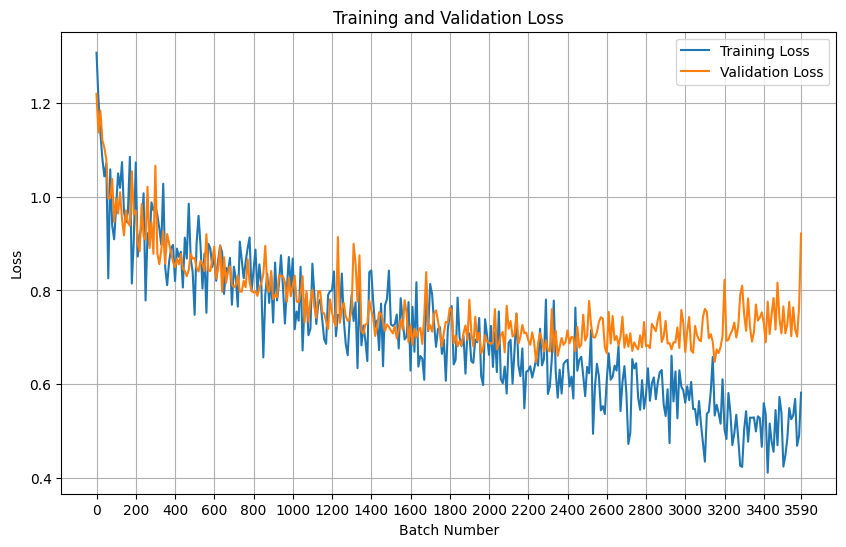

In [116]:

x_axis = list(map(lambda x:x*10,range(len(train_loss))))
plt.figure(figsize=(10,6))
plt.plot(x_axis ,train_loss, label='Training Loss')
plt.plot(x_axis , val_loss,label='Validation Loss')
xticks = np.arange(x_axis[0], x_axis[-1]+1, 200.0)
plt.xticks([*xticks, x_axis[-1]])
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

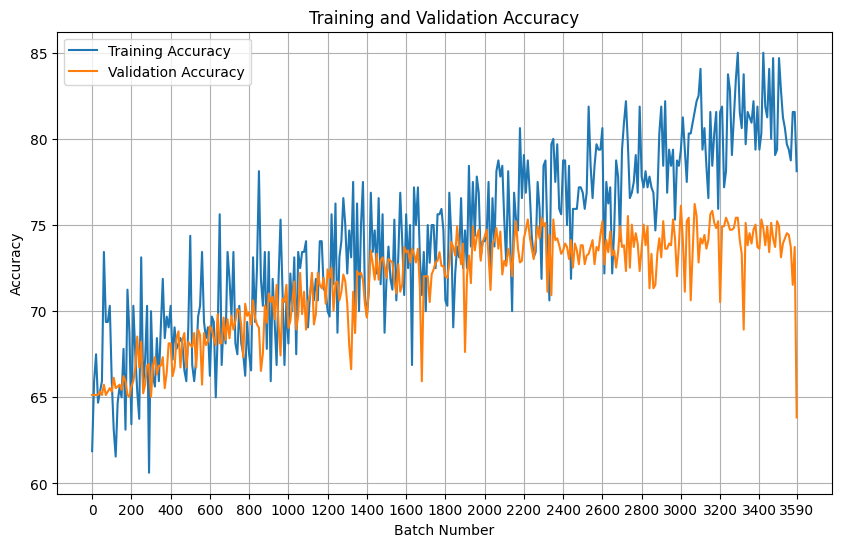

In [117]:
x_axis = list(map(lambda x:x*10,range(len(train_accuracy))))
plt.figure(figsize=(10,6))
plt.plot(x_axis ,train_accuracy, label='Training Accuracy')
plt.plot(x_axis , val_accuracy,label='Validation Accuracy')
xticks = np.arange(x_axis[0], x_axis[-1]+1, 200.0)
plt.xticks([*xticks, x_axis[-1]])
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [30]:
from torchsummary import summary
from ComplexConvNN import ComplexConvNN

M = 100
N = 125
transforms = create_transform(M, N)
dataset = MLProject2Dataset(data_dir='data', metadata_fname='metadata.csv', transform=transforms)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [.6, .1, .3],
                                                                         generator=torch.Generator().manual_seed(42))

BATCH_SIZE = 32
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = ComplexConvNN()
model = model.to(device)
summary(model, (3, M, N))
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()
train_net(model, trainloader, valloader, epochs=20, optimizer=optimizer, loss=loss, device=device)
test_net(model, testloader, loss=loss, device=device)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 98, 123]             896
       BatchNorm2d-2          [-1, 32, 98, 123]              64
         MaxPool2d-3           [-1, 32, 49, 61]               0
            Conv2d-4           [-1, 64, 47, 59]          18,496
       BatchNorm2d-5           [-1, 64, 47, 59]             128
         MaxPool2d-6           [-1, 64, 23, 29]               0
            Conv2d-7          [-1, 128, 21, 27]          73,856
       BatchNorm2d-8          [-1, 128, 21, 27]             256
         MaxPool2d-9          [-1, 128, 10, 13]               0
           Conv2d-10           [-1, 256, 8, 11]         295,168
      BatchNorm2d-11           [-1, 256, 8, 11]             512
        MaxPool2d-12            [-1, 256, 4, 5]               0
           Conv2d-13            [-1, 512, 2, 3]       1,180,160
      BatchNorm2d-14            [-1, 51